## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
from tqdm import tqdm
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import euclidean_distances

## Read in data from paper

In [2]:
import numpy as np
import pandas as pd

# df_1 is a control gene expression matrix with mice completely deprived of light 
df_1 = pd.read_csv("data/neuro_circ/sheet_1.csv", header=None).T
# df_2 is the experimental gene expression matrix with mice exposed to 1 hour light 
df_2 = pd.read_csv("data/neuro_circ/sheet_2.csv", header=None).T

# NOTE: within each of {df_1, df_2}, Cell_number is a unique ID,
# so each row (post-transpose) is a unique cell

# Set columns
df_1.columns = df_1.iloc[0]
df_1.drop(df_1.index[0], inplace=True)
df_2.columns = df_2.iloc[0]
df_2.drop(df_2.index[0], inplace=True)

names_1 = df_1["Animal_Number"].tolist()
names_2 = df_2["Animal_Number"].tolist()
names = names_1 + names_2
uniq_names = np.unique(names)

groups_1 = df_1["core_group"].tolist()
groups_2 = df_2["core_group"].tolist()
groups = groups_1 + groups_2
uniq_groups = np.unique(groups)

# Drop irrelevant columns
to_drop = ['Cell_number', 'Animal_Number', 'core_group',
	'Light_treat', 'Rostral_Caudal', 
	'Ventral_Dorsal', 'Medial_Lateral']
df_1.drop(labels=to_drop, axis=1, inplace=True)
df_2.drop(labels=to_drop, axis=1, inplace=True)

In [3]:
# ensure no nan values
df_1 = df_1.replace(np.nan, 0)
df_2 = df_2.replace(np.nan, 0)

In [4]:
# generate UMAP for visualization
reducer = umap.UMAP()
UMAP = reducer.fit_transform(df_2.values)
print(UMAP.shape)

# save UMAP if desired
#savetxt('circadian_umap.csv', UMAP, delimiter=',')

(323, 2)


No handles with labels found to put in legend.


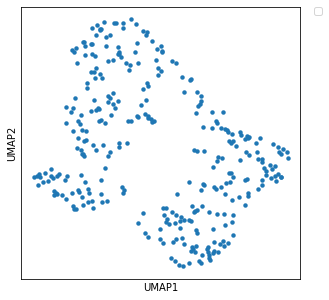

In [5]:
plt.figure(figsize=(5, 5))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [6]:
# computing the distance matrix for mSVD
np_data = df_2.values.T
N, d = np_data.shape
 
dist_mat = euclidean_distances(np_data, np_data)

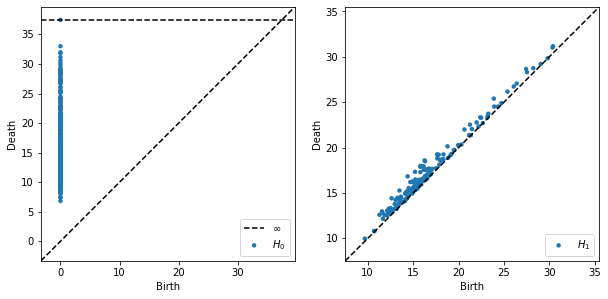

In [7]:
# Ripser to assess homology
dgms = ripser(np_data.T, maxdim=1)['dgms']

# plotting individially
plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

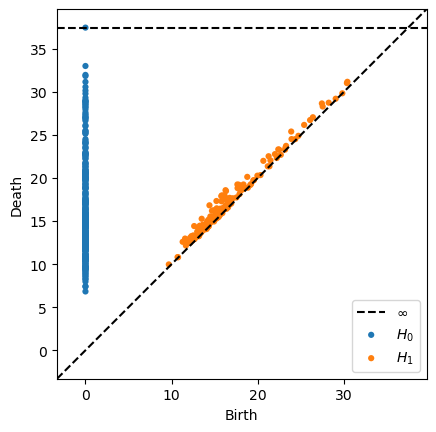

In [8]:
# group plot
plot_diagrams(dgms, show=True)

## Investigating ways to reduce the influence of "noise" dimensions

In [9]:
from sklearn.decomposition import PCA

### Subsetting by principle components

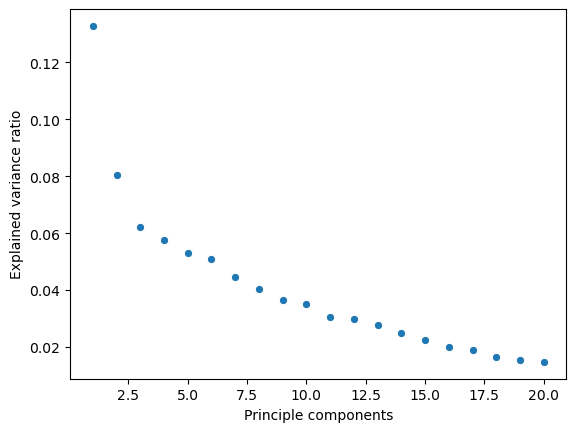

In [10]:
# using the first 10 PCs as a way to omit the influence of noisy, uninformative measurements
pca = PCA(n_components=20)
pca.fit(df_1.values)
PC = pca.transform(df_1.values)

var = np.array(pca.explained_variance_ratio_)
pcs = np.arange(1,21)

sns.scatterplot(pcs, var)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.show()

In [11]:
data = PC[:,0:10]

No handles with labels found to put in legend.


(323, 2)


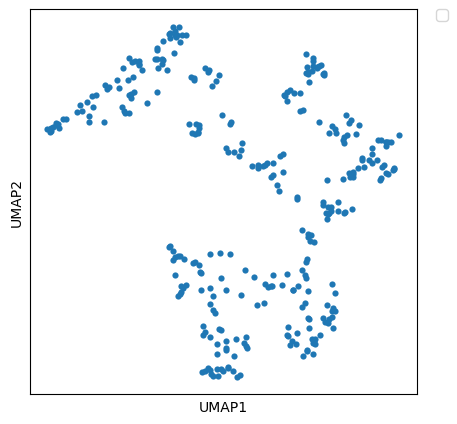

In [12]:
# dimensionally reduced visualization of this data
reducer = umap.UMAP()
UMAP = reducer.fit_transform(data)
print(UMAP.shape)

plt.figure(figsize=(5, 5))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(323, 10)


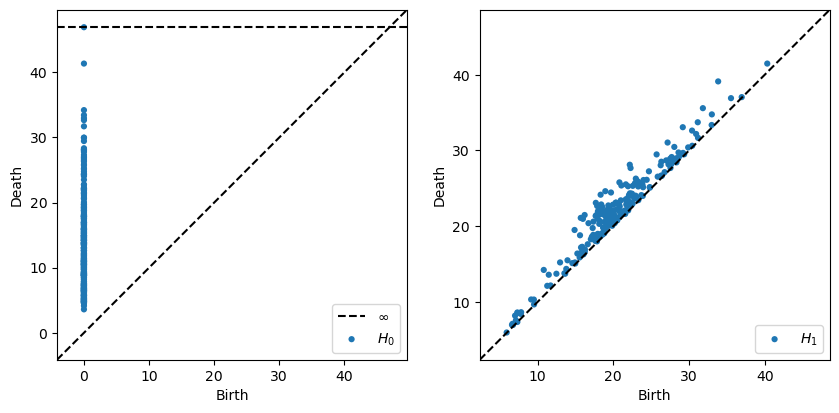

In [13]:
# Ripser to assess homology
print(data.shape)
dgms = ripser(data, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

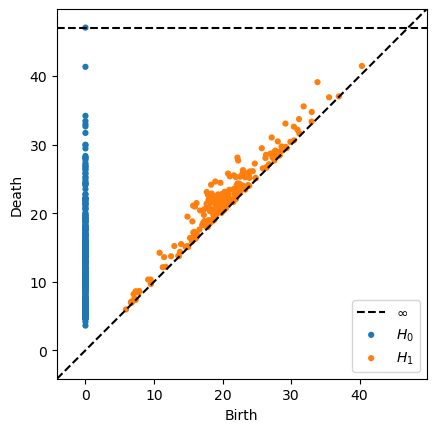

In [14]:
plot_diagrams(dgms, show=True)

### Subsetting by gene list

In [16]:
# ls is the list of genes inplicated in this cycle in the paper
ls = ["rora","drd1a","prokr2","arntl","egr2","rasd1","per2","rasa1","cry1","gabra1","csnk1e","gsk3b","adcyap1r1","egr1"]
pd_data = df_2[ls]

No handles with labels found to put in legend.


(323, 2)


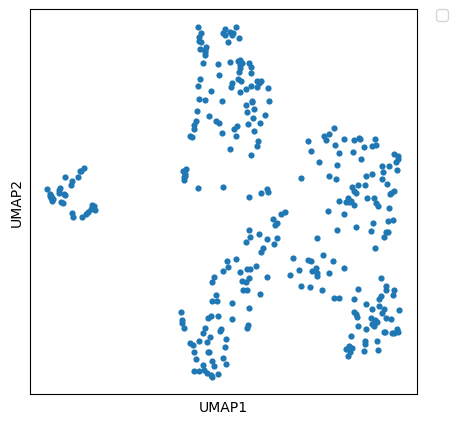

In [17]:
# dimensionally reduced visualization of this data
reducer = umap.UMAP()
UMAP = reducer.fit_transform(pd_data.values)
print(UMAP.shape)

plt.figure(figsize=(5, 5))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(323, 14)


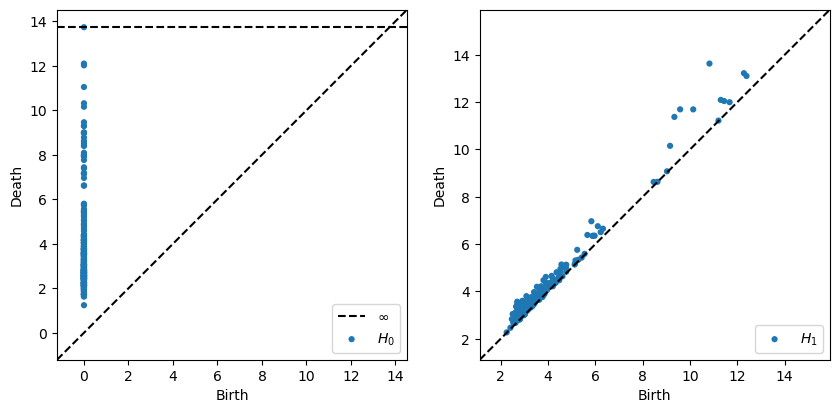

In [18]:
# Ripser to assess homology
print(pd_data.values.shape)
dgms = ripser(pd_data.values, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

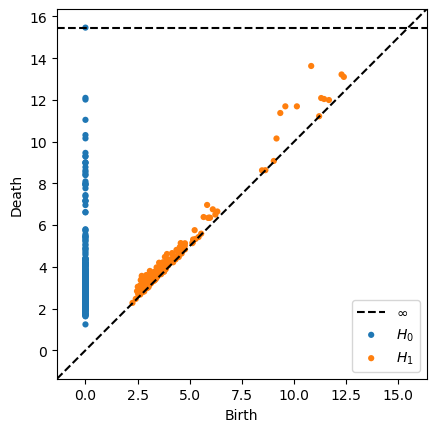

In [19]:
plot_diagrams(dgms, show=True)